# **Demodulador 16QAM basado en Redes Neuronales Multicapa (ARN)**

**Profesor-Asesor:** Germán David Goez Sánchez

**Autores:** Julian David Mosquera Cano, Sebastián Ortiz Pérez, Andrés Felipe Molina López

Instituto Tecnológico Metropolitano, Medellin-Colombia (ITM)

Este notebook se compone de dos partes en ambas se implementa un diseño de una red neuronal multicapa. La primera parte consta de un método de aprendizaje asistido usando las librerías sklearn y keras, y la segunda parte se usa un método de aprendizaje NO supervisado con el algoritmo de clasificación Kmeans.

Para un demodulador QAM la técnica de secuencia de entrenamiento asistido pueden mitigar en gran medida los deterioros de la señal causados por el ruido de emisión espontáneo amplificado en el trayecto de la señal, también, esta metodología se ha aplicado ampliamente para aumentar la capacidad de transmisión de fibra y aumentar el tráfico de red.

De la misma manera, el algoritmo ciego k-means se utiliza para reducir significativamente la complejidad del cálculo y la redundancia de datos mediante una técnica que rastrea con precisión los centroides de los conglomerados tambien llamado clustering. 

Ambos algoritmos cumplen el rol de optimizar la decisión a donde pertenece el símbolo para mejorar el rendimiento BER.

In [1]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split #separar datos de entrenamiento y clasificación
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder #activar neurona de salida según predicción  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from IPython.display import HTML, display_html, display

In [2]:
signal = pd.read_csv('Dataset_16QAM.csv',index_col=0)
df = pd.DataFrame(signal)
df
display(HTML('<h2>Tabla 1</h2><h3>Dataset 16-QAM</h3>'))
display_html(df)

,Real,Imaginario,Map,oReal,oImaginario
0,3.063766,-0.965054,9.0,3.0,-1.0
1,-0.914516,4.923785,6.0,-1.0,3.0
2,1.274280,2.206067,15.0,1.0,1.0
3,4.597829,-0.649312,9.0,3.0,-1.0
4,-0.371869,-3.759572,12.0,1.0,-3.0
...,...,...,...,...,...
995,-0.432652,3.421091,6.0,-1.0,3.0
996,-1.158105,3.466756,6.0,-1.0,3.0
997,1.452283,2.827832,14.0,1.0,3.0
998,-0.121111,-2.951948,4.0,-1.0,-3.0


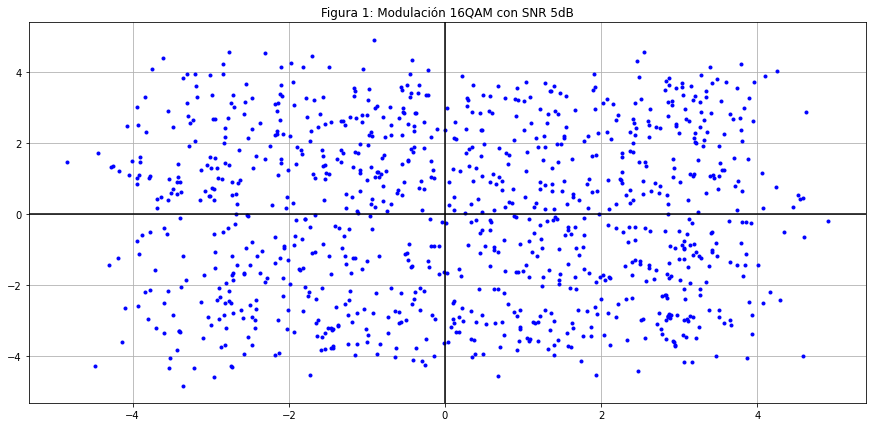

In [3]:
x = df.iloc[:,[0,1]].values
xv = df.iloc[:,[3,4]].values
y = df.iloc[:,2]
plt.figure(figsize=(15,7))
plt.plot(x[:,0],x[:,1],'b.')
#Los metodos axhline y axvline generan las lineas negras en forma de cruz
plt.axhline(0, color="black")
plt.axvline(0, color="black")

plt.title("Figura 1: Modulación 16QAM con SNR 5dB")
plt.grid()

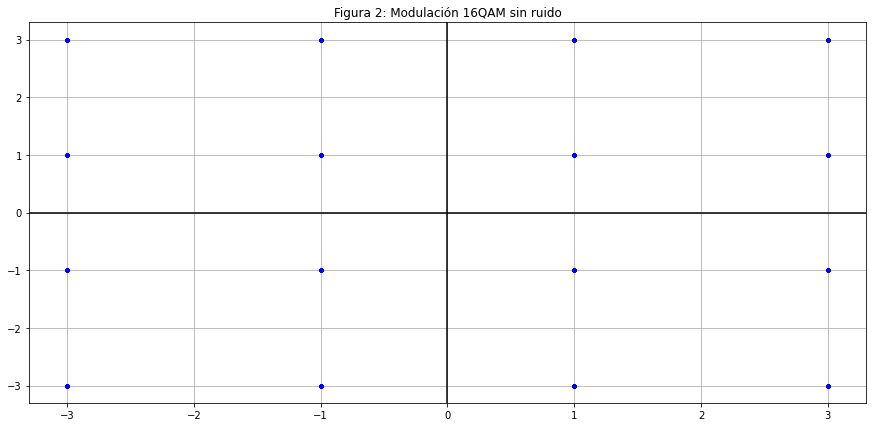

In [4]:
plt.figure(figsize=(15,7))
plt.plot(xv[:,0],xv[:,1],'b.')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.title("Figura 2: Modulación 16QAM sin ruido")
plt.grid()

# Parte 1- Aprendizaje Supervizado con sklearn y keras

Primeramente, se implementa el diseño del demodulador 16-QAM basado en una red neuronal multicapa supervisado con keras y sklearn alimentando la red con los símbolos ideales determinados en la variable "y" como se enseña en a figura 2; consiguiente, del mismo dataset se le entregan 20% de los datos transformados a la función train_test_split para entrenar la red neuronal y se diseña la arquitectura teniendo en cuenta que el entrenamiento es una metodología estocástica se da lugar a la configuración de capas con mejores resultados.

Obteniendo finalmente el reporte de clasificación y la matriz de confusión los cuales indican que tan efectivo fue el aprendizaje.

In [5]:
#====Parte 1=============================================================================

## Pasar el número de columna creando una variable ficticia
# Codificación en caliente de las etiquetas de clase
encoder = OneHotEncoder(sparse=False)
mt = np.array(y)

#Convertir los datos a columna simple
y_ = mt.reshape(-1, 1)

#Se hace la transformada
xen = encoder.fit_transform(y_)

##Dividir los datos en el conjunto de entrenamiento y el conjunto de prueba. 
#Mantenemos la relación de división de tren a prueba en 80:20
X_train, X_test, y_train, y_test = train_test_split(x, xen, test_size = 0.2)
print(xen)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
##Normalizamos la escala, de modo que se utilice el mismo método ajustado para transformar / escalar los datos de prueba.
# Escalado de características
sc = StandardScaler() 
X_train2 = sc.fit_transform(X_train) 
X_test2 = sc.transform(X_test)

In [7]:
## Semilla del generador aleatorio, garantiza la reproducibilidad del entrenamiento 
##(es decir que lleguemos a los mismos resultados cada vez que ejecutemos el código).

np.random.seed(100)

# Construccion del modelo
model = Sequential()
model.add(Dense(5, input_shape=(2,), activation='relu', name='Layer1'))
model.add(Dense(8, activation='relu', name='Layer2'))
model.add(Dense(16, activation='relu', name='Layer3'))
model.add(Dense(16, activation='sigmoid', name='output'))

# Optimizador Adam con tasa de aprendizaje de 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer,loss="sparse_categorical_crossentropy", metrics=['accuracy'])
print('Resumen del modelo de red neuronal: ')
print(model.summary())

Resumen del modelo de red neuronal: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 5)                 15        
                                                                 
 Layer2 (Dense)              (None, 8)                 48        
                                                                 
 Layer3 (Dense)              (None, 16)                144       
                                                                 
 output (Dense)              (None, 16)                272       
                                                                 
Total params: 479
Trainable params: 479
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# Entrenando el modelo
reporte = model.fit(x, y, verbose=2, batch_size=5, epochs=50)

Epoch 1/50
200/200 - 0s - loss: 2.6213 - accuracy: 0.0810 - 351ms/epoch - 2ms/step
Epoch 2/50
200/200 - 0s - loss: 2.1463 - accuracy: 0.2670 - 108ms/epoch - 540us/step
Epoch 3/50
200/200 - 0s - loss: 1.5976 - accuracy: 0.4380 - 113ms/epoch - 565us/step
Epoch 4/50
200/200 - 0s - loss: 1.2727 - accuracy: 0.5500 - 109ms/epoch - 545us/step
Epoch 5/50
200/200 - 0s - loss: 1.1112 - accuracy: 0.5900 - 101ms/epoch - 505us/step
Epoch 6/50
200/200 - 0s - loss: 1.0206 - accuracy: 0.6290 - 100ms/epoch - 500us/step
Epoch 7/50
200/200 - 0s - loss: 0.9509 - accuracy: 0.6370 - 96ms/epoch - 480us/step
Epoch 8/50
200/200 - 0s - loss: 0.9084 - accuracy: 0.6540 - 97ms/epoch - 485us/step
Epoch 9/50
200/200 - 0s - loss: 0.8622 - accuracy: 0.6740 - 96ms/epoch - 480us/step
Epoch 10/50
200/200 - 0s - loss: 0.8285 - accuracy: 0.6990 - 100ms/epoch - 500us/step
Epoch 11/50
200/200 - 0s - loss: 0.8075 - accuracy: 0.7080 - 103ms/epoch - 515us/step
Epoch 12/50
200/200 - 0s - loss: 0.7819 - accuracy: 0.7050 - 103ms/e

In [9]:
# evaluamos el modelo
scores = model.evaluate(x, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print (model.predict(x).round())

32/32 [==============================] - 0s 581us/step - loss: 0.5775 - accuracy: 0.7670

accuracy: 76.70%
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [10]:
# Prueba en datos no vistos
results = model.evaluate(x, y)
print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

32/32 [==============================] - 0s 613us/step - loss: 0.5775 - accuracy: 0.7670
Final test set loss: 0.577484
Final test set accuracy: 0.767000


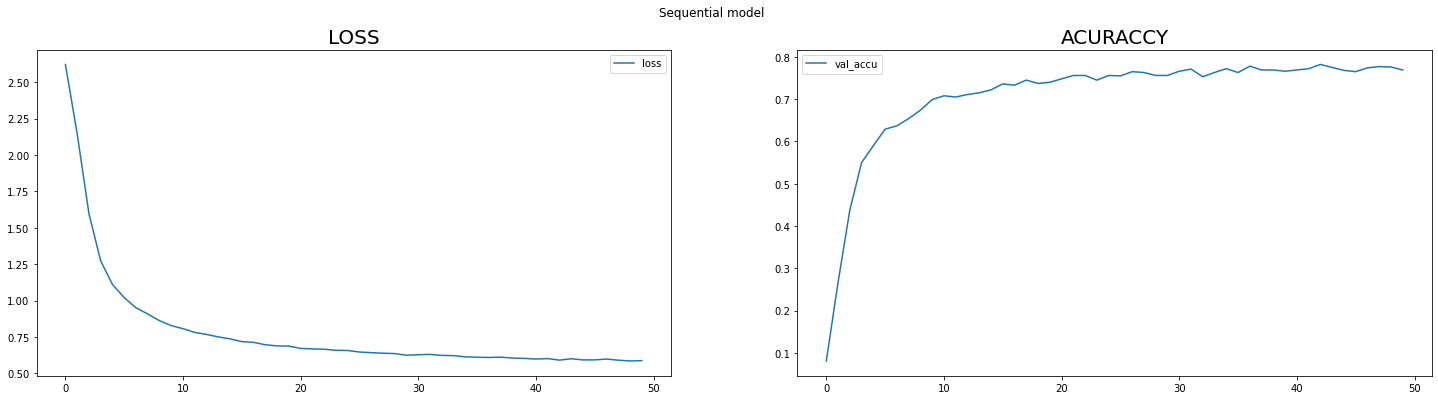

In [11]:
import matplotlib.pyplot as plt
val_loss = reporte.history['loss']
val_accu = reporte.history['accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,6))
fig.suptitle('Sequential model')
ax1.plot(val_loss,label='loss')
ax1.set_title('LOSS',fontsize=20)
ax1.legend()
ax2.plot(val_accu,label='val_accu')
ax2.set_title('ACURACCY',fontsize=20)
ax2.legend()

In [12]:
predict = model.predict(x)
predict2 = model.predict(xv)
predict = np.around(predict)
predict2 = np.around(predict2)
predict
predict2

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

C:\Users\Sebastian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      0.67      0.79        92
           1       0.88      0.55      0.68        76
           2       0.98      0.55      0.70        97
           3       0.79      0.70      0.74       132
           4       0.89      0.70      0.78       164
           5       0.66      0.38      0.48        82
           6       0.90      0.80      0.85       133
           7       0.83      0.46      0.59       107
           8       0.76      0.93      0.84       174
           9       0.94      0.68      0.79       195
          10       1.00      0.72      0.84       107
          11       0.82      0.72      0.77       155
          12       0.99      0.74      0.85       188
          13       0.88      0.62      0.73       197
          14       0.82      0.83      0.83       136
          15       0.67      0.61      0.64       136

   micro avg       0.86      0.69      0.76      2171
   macro avg       0.86   

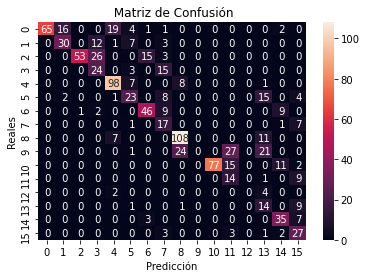

In [13]:
# Matriz de confusión 1

import seaborn as sns

cf_matrix1 = confusion_matrix(np.asarray(predict).argmax(axis=1), np.asarray(predict2).argmax(axis=1))
ax= plt.subplot()
sns.heatmap(cf_matrix1, annot=True, fmt='2g', ax=ax)
#sns.heatmap(cf_matrix1, annot=True, cmap=plt.cm.Blues,fmt='g', ax=ax)
ax.set_xlabel('Predicción');ax.set_ylabel('Reales'); 
ax.set_title(' Matriz de Confusión'); 
print (classification_report( predict, predict2))

# Analisis de resultados-Aprendizaje Supervizado

Teniendo en cuenta que el "accuracy" representa la exactitud que tuvo el modelo con respecto al porcentaje total de predicciones correctas, es decir, el cociente de los valores en la diagonal de la matriz de confusión (verdaderos positivos y verdaderos negativos) sobre el total de los datos.
Y "precision" es la precisión que se refiere a lo cerca que está el resultado de una predicción del valor verdadero, o sea, es la relación entre los casos positivos bien clasificados (verdaderos positivos) por el modelo y el total de predicciones positivas (verdaderos positivos +verdaderos negativos).

Se tiene que, la precisión obtenida por el modelo supervisado es de un aproximado de 64% mientras que la exactitud ronda el 77.5%. Por lo tanto, nuestro modelo es más exacto que preciso, en otras palabras, la mayoría de datos de la predicción se acercan al símbolo más  de lo que el símbolo que pertenece al centro ideal coincide con dicho centro; que para la solución del problema en específico por ser 16-QAM o sea 16 símbolos, 4 símbolos por cuadrante los datos se clasificaran de manera correcta, sin embargo, para diferentes modulaciones con más símbolos esta falta de precisión podría generar un entrecruzamiento de símbolos desviandolo de su respectivo centro conllevando a una pérdida de datos significativa.

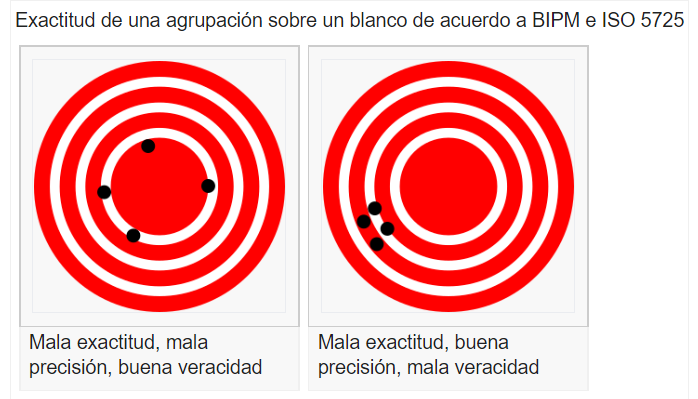


# Parte 2- Aprendizaje No Supervizado con KMeans

En esta segunda parte se aplica el algoritmo ciego k-means el cual analiza la parte real e imaginaria de la señal verdadera para obtener los 16 centroides correspondientes a los 16 símbolos. Después, se usan estos inexactos centroides para encontrar los conglomerados adyacentes y usar esos clústers para obtener todos y cada uno hasta el dieciseisavo centroide, es decir, este calcula la distancia entre los centroides de primera generación y reorganiza cada dato a los grupos de acuerdo con la distancia mínima, calculando la media de cada grupo para así lograr los centroides actualizados y finalmente todos los datos se asignan a uno de los 16 grupos correspondientes.

En resumen, el algoritmo clásico sin supervisión k-means es un algoritmo iterativo en cual el número de clúster o grupos deben ser determinados antes de la ejecución, además, el algoritmo k-means selecciona los puntos iniciales aleatoriamente, que son cercanos entre sí o en el peor de los casos valores atípicos de los grupos dando resultados insatisfactorios.

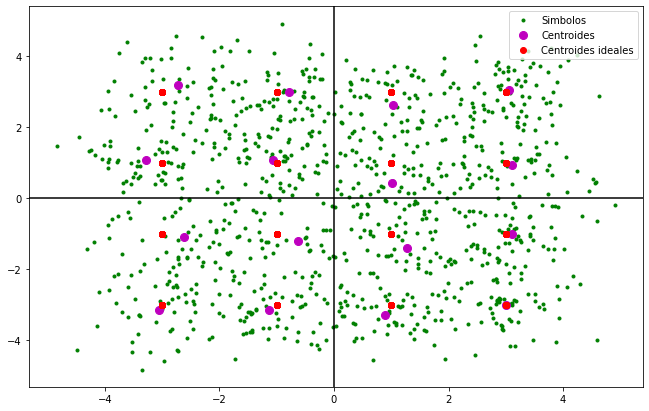

In [14]:
#====Parte 2===========================================================================================

from sklearn.cluster import KMeans

n = 16

#entrenamiento con ruido
k_means = KMeans(n_clusters=n)
k_means.fit(x)

centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

plt.figure(figsize=(11,7))
plt.plot(x[:,0],x[:,1],'g.', label='Simbolos')
plt.plot(centroides[:,0],centroides[:,1],'mo',markersize=8, label='Centroides')
plt.plot(xv[:,0],xv[:,1],'r.',markersize=12,label='Centroides ideales')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.legend(loc='best')
plt.show()

In [15]:
#predicciones
y_kmeans = k_means.predict(x)
y_km2 = k_means.predict(xv)

In [16]:
# Matriz de confusión2

cf_matrix2 = confusion_matrix(y_kmeans,y_km2)
print(cf_matrix2)
print(classification_report(y_kmeans,y_km2))
print("Exactitud: ",(accuracy_score(y_kmeans,y_km2, normalize=False)/len(df.iloc[:,[0]].values))*100,"%")

[[51  0  0  0  0  0  0  0  0  0  2  0  0  0  0  1]
 [ 0 28  2  0  0  0  0  0  0  0  1  0  7  0  0  4]
 [ 0  1 37  0  0  0  0  0  3  0  0  3 22  3  0  0]
 [ 0  0  0 58  0  0  5  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0 45  0  0  4  0  7  0  1  0  0  0  0]
 [ 0  0  0  0  0 70  0  0  0  0  0  0  0  3  6  0]
 [ 0  0  0  3  0  0 53  0  0  0  0  0  0  0  0  7]
 [ 0  0  0  0  6  0  0 51  0  0  4  0  0  0  0  0]
 [ 0  0  0  4  0  0  1  0 53  0  0  0  5  5  0  0]
 [ 0  0  0  0  3  0  0  1  0 45  0  4  0  0  9  0]
 [ 6  7  0  0  0  0  0  3  0  0 39  2  0  0  0  1]
 [ 0  4  6  0  0  0  0  5  0 11  2 49  0  0  1  0]
 [ 0  2  0  6  0  0  5  0  5  0  0  0 32  0  0  0]
 [ 0  0  3  0  0  3  0  0  6  0  0  0  2 46  0  0]
 [ 0  0 17  0  0  4  0  0  0  2  0  0  0  2 44  0]
 [ 8  5  0  0  0  0  7  0  0  0  0  0  0  0  0 44]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.86        54
           1       0.60      0.67      0.63        42
           2       0

In [17]:
#imprimir reporte acuracy sklearn para n etiquetas
#print(classification_report(y_kmeans, y_km2, labels=[0,1,2,3,4,5]))

In [18]:
# Guardar modelo
path_model = 'model.keras'
model.save(path_model)

In [19]:
# cargar modelo
from tensorflow.python.keras.models import load_model
model3 = load_model(path_model)
model3.summary()
p = np.around(model3.predict(X_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Dense)               (None, 5)                 15        
_________________________________________________________________
Layer2 (Dense)               (None, 8)                 48        
_________________________________________________________________
Layer3 (Dense)               (None, 16)                144       
_________________________________________________________________
output (Dense)               (None, 16)                272       
Total params: 479
Trainable params: 479
Non-trainable params: 0
_________________________________________________________________


# Análisis de resultados-Aprendizaje No Supervisado

Se observa que, la técnicas propuesta basadas en KMeans pueden reducir la complejidad y redundancia de datos, también, al tener mayor precisión el rendimiento en el BER mejora, además, el algoritmo blind KMeans tiene una estructura más simple y se puede usar para manejar datos a gran escala aumentando la eficiencia de procesamiento.

Según la matriz de confusión, La sensibilidad (o recall) que es la habilidad del modelo de detectar los casos relevantes. Arroja un 74% de promedio es claramente un valor aceptable aunque no suficiente para garantizar la fidelidad de cualquier mensaje pues dependerá de la región de decisión del demodulador, sin embargo si se pretende optimizar el BER el algoritmo Clustering KMeans ayuda significativamente a que el demodulador no tenga que solicitar el reenvío del paquete por tasa de errores a menudo.

# Comparación de resultados y Conclusiones
Después de analizar ambos modelos se puede afirmar que para una demodulación 16-QAM con un SNR de 5 dB, el modelo que mejor resultados obtuvo fue el algoritmo no supervisado KMeans siendo un 10% superior a su contraparte supervisada Keras-sklearn, infiriendo que el modelo supervisado al leer parte del dataset como datos de entrenamiento tendera a tener un sesgo más elevado que el método de K-means que analiza dato por dato y su distancia euclidiana al centroide. Cabe destacar que estos no son resultados contundentes pues hay simulaciones donde el contraste entre modelos varía y depende directamente de las siguientes razones:
Cuando aumentamos las épocas las gráficas caracterizan un sobreapredizaje del modelo supervisado, complementariamente al depurar iterativamente entre diferentes arquitecturas se comprometían la precisión, exactitud y recall de ambos modelos. (se elige la más optima basados en la matriz de confusión y reporte de clasificación). 

Después del umbral de capas y neuronas propuesto si se insertan más neuronas o más capas, no se refleja resultados significativamente diferentes. 

En el modelo supervisado si se incrementa la muestra de entrenamiento es consecuente a obtener mejor precisión y menos perdidas, sin embargo, a partir de 50% como muestra de entrenamiento no se genera cambios significativos incluso tiende a empeorar.

Finalmente, el valor máximo de rendimiento de ambos modelos no pasa del 80% debido a que la señal entregada por defecto tiene una SNR de 5dB y la dispersión de los símbolos está dada por el ruido en canal de transmisión sea fibra o aire sabiendo que este fenómeno se mitiga directamente aumentando el SNR de la señal. Se puede concluir que estas técnicas se diseñaron para optimizar el uso de recursos energéticos. Pues si se aumenta el SNR se requiere más potencia de transmisión y que la implementación de una red neuronal sea mas rentable costo beneficio para evitar sobrecostes de infraestructuras, energía y talento humano, cumple con la macrotendencia de tecnología sustentable lo que es un valor agregado para cualquier empresa.
